# Trabajo Practico 1
## Maximización del Ratio de Sharpe con Derivadas Numéricas

El ratio de Sharpe está definido como:

$$
S(w) = \frac{w^\top \mu - r_f}{\sqrt{w^\top \Sigma w}}
$$

donde:

- **\( w \)** es el vector de pesos del portafolio,  
- **\( \mu \)** es el vector de rendimientos esperados,  
- **\( r_f \)** es la tasa libre de riesgo,  
- **\( \Sigma \)** es la matriz de covarianzas.

# Ejercicio 1

In [ ]:
import numpy as np
import matplotlib.pyplot as plt


class Portfolio():
    def __init__(self, weights, returns, rf, penalty=False):
        # Weighst = tupla con los w de los 3 activos
        # Returns = Lista de 3 tuplas con los retornos de los 3 activos
        self.penalty=penalty
        self.returns = np.array(returns)
        self.mus = self.mu()
        self.weights = self.check_weights(weights)
        self.rf = rf
        self.cov_matrix = np.cov(returns)

    def check_weights(self, weights):
        check = 0
        for i in weights:
            check += i
        if check != 1:
            raise ValueError("La suma de los weights debe ser 1.")

        # Si vienen 2 weights, infiero el tercero
        if len(weights)==2:
            weights = np.append(weights, 1-weights.sum())
        return np.array(weights)

    def mu(self):
        prom_r = []
        for i in self.returns:
            i = np.mean(i)
            prom_r.append(i)
        return np.array(prom_r)

    def portfolio_return(self, weights=None):
        if weights is None:
            weights = self.weights
        return weights @ self.mus

    def portfolio_volatility(self, weights=None):
        if weights is None:
            weights = self.weights
        return np.sqrt(weights @ self.cov_matrix @ weights)

    def sharpe_ratio(self, weights=None, ponderador = 15000): #cambiar nombre a menos sharpe/o agregar un parametro que haga el return negativo
        if weights is None:
            weights = self.weights
        elif len(weights)==2:
            weights = np.append(weights,1-sum(weights))
        S = (self.portfolio_return(weights) - self.rf) / self.portfolio_volatility(weights)
        if self.penalty:
            # Penaliza si hay pesos negativos
            penalty_term = ponderador * np.sum(np.minimum(weights, 0)**2)
            return S - penalty_term
        else:
            return S
    
weights = (0.1, 0.5, 0.4)
returns = [
    (0.10, 0.20, 0.15, 0.12, -0.10),
    (0.05, 0.10, 0.12, 0.08, -0.05),
    (0.20, 0.25, 0.22, 0.21,  0.15),
]
rf = 0.03
p = Portfolio(weights, returns, rf)

print("Sharpe Ratio:", p.sharpe_ratio())
print("Portfolio Return:", p.portfolio_return())


Sharpe Ratio: 1.5721160315356602
Portfolio Return: 0.12180000000000002


# Ejercicio 2

El gradiente del Sharpe respecto de \(w_1 , w_2\) usando diferencias centrales es:

\[
\begin{bmatrix}
\dfrac{S(w_1+h,\,w_2) - S(w_1-h,\,w_2)}{2h} \\
\dfrac{S(w_1,\,w_2+h) - S(w_1,\,w_2-h)}{2h}
\end{bmatrix}
\]

Para la restriccion utilizamos una penalizacion que cuando vos tenes pesos muy negativos termina restandoles al sharp en su ecuacion

$$
P(\mathbf{w})=\sum_{i=1}^{3}(\min\{w_i,0\})^2
$$

In [14]:
def gradient_sharpe(cartera, w, Penalty = False):
        """
        Esta función hace la derivada centrada del
        ratio de Sharpe, evaluada en el punto que
        el usuario ingrese.
        Por default usa como funcion a derivar el 
        ratio de sharpe sin la penalidad, pero el 
        usuario puede elegir si desea derivar la 
        funcion que involucra la penalidad cuando
        alguno de los weights son < 0.
        
        Returns: Gradiente
        """
        h = 10e-4  # El movimiento marginal de la derivada
        if w is None:
            w = cartera.weights[:2:]
        #Derivada parcial resp de w1:
        
        fx = (cartera.sharpe_ratio(np.array([w[0] + h, w[1]])) - cartera.sharpe_ratio(np.array([w[0] - h, w[1]])))/(2*h)
        #Derivada parcial resp de w2:
        fy = (cartera.sharpe_ratio(np.array([w[0], w[1] + h])) - cartera.sharpe_ratio(np.array([w[0], w[1] - h])))/(2*h)

        return np.array([fx, fy]) #Gradiente

def gdscent(cartera, e = 10e-5,n=100000,graph=False):
    """ Esta función recibe por parte del usuario un vector de ponderadores inicial del portafolio. Mediante el uso de derivadas 
    centradas y el algoritmo de descenso por gradiente de -f(X) maximiza el ratio de Sharpe. """

    # En cada iteración, se debera crear un nuevo vector de weights que se convertira otro objeto de la clase Portfolio.
    # Los retornos y la risk free se mantienen con el mismo valor (W0).
    w0 = cartera.weights[:2:]
    rf = cartera.rf
    historial_w = np.array([])
    historial_sharpes = np.array([])
    # Evaluo el sharpe en el punto W0
    # Agregamos un menos adelante, porque queremos maximizar una función con un metodo de minimizacion
    for i in range(n):
        Y0 = cartera.sharpe_ratio(w0) 

        # Calculo la derivada centrada en W0
        dY = gradient_sharpe(cartera, w0)

        # Calculo mi nuevo w0 retrocediendo a tasa e en contra del gradiente, la direccion de maximo crecimiento
        w0 = w0 - e * (-dY)

        # Evaluo el shrape en mi nuevo punto W1
        Y1 = cartera.sharpe_ratio(w0)
        
        #Si la distancia en valor absoluto entre f(W1) y f(W0) es muy chica, decimos que encontramos el vector de weights que maximiza el sharpe dada una rf
        if abs(Y1-Y0) < 10e-8:
            w0 = np.append(w0,1-sum(w0))
            sharpe = cartera.sharpe_ratio(w0)
            if graph:
                x = 0 
                # w0 es el vector de weights que maximiza el sharpe
                # sharpe es el sharpe max
                # historial de w y sharpes nos serviran para graficar la trayectoria.
                return w0 , sharpe, historial_w , historial_sharpes
            return w0 , sharpe
        else:
            historial_w = np.append(historial_w, [ [w0[0], w0[1]] ])
            historial_sharpes = np.append(historial_sharpes, -Y1)
            continue


##### Pruebas #####        
weights = (0.2, 0.5, 0.3)
returns = [(0.1, 0.2, 0.15, 0.12, -0.1), (0.05, 0.1, 0.12, 0.08, -0.05), (0.2, 0.25, 0.22, 0.21, 0.15)]
rf = 0.03
p = Portfolio(weights, returns, rf)


w_opt, sharpe_opt, recorrido_w, recorrido_sharpe = gdscent(p, graph=True)
print("Óptimo:", w_opt, "Sharpe:", sharpe_opt)
print(p.weights)

#plot_sharpe_superficie(p, w_opt, sharpe_opt) NO VAN
#plot_trayectoria_gradiente(recorrido_w, recorrido_sharpe, w_opt, sharpe_opt)

Óptimo: [-0.52388295  0.21212792  1.31175504] Sharpe: 22.427838344206958
[0.2 0.5 0.3]


# Ejercicio 4

Óptimo: [-0.52388295  0.21212792  1.31175504] Sharpe: 22.427838344206958
[0.2 0.5 0.3]


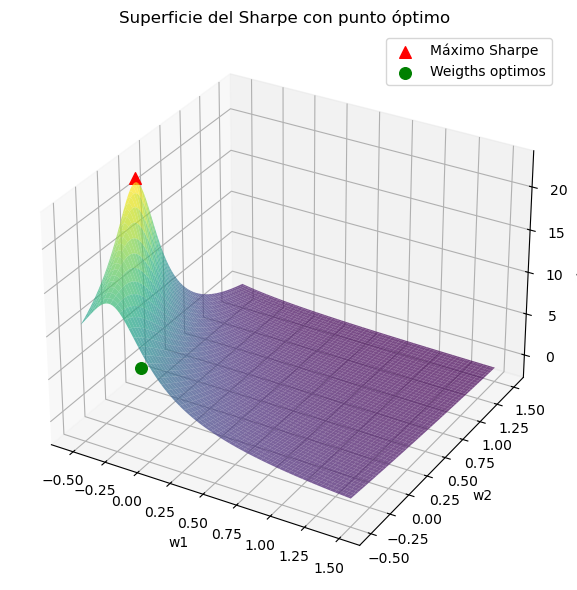

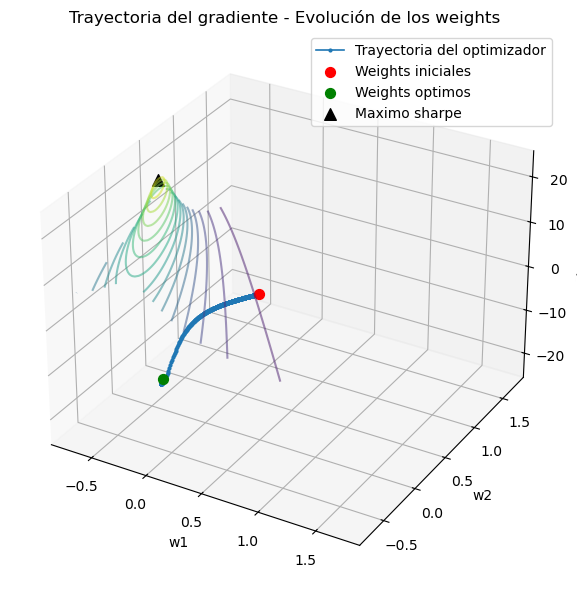

In [15]:
def plot_sharpe_superficie(cartera, w_opt, sharpe_opt,
                           w1_lim=(-0.5,1.5), w2_lim=(-0.5,1.5), grid=120):
    """
    Superficie z = S(w1,w2,1-w1-w2) y el punto óptimo.
    sharpe_xy: función (w1,w2) -> Sharpe positivo
    w_opt: vector (w1,w2,w3) óptimo
    sharpe_opt: valor Sharpe en el óptimo
    """
    w1 = np.linspace(*w1_lim, grid)
    w2 = np.linspace(*w2_lim, grid)
    W1, W2 = np.meshgrid(w1, w2)

    Z = np.empty_like(W1)
    for i in range(W1.shape[0]):
        for j in range(W1.shape[1]):
            Z[i,j] = cartera.sharpe_ratio(np.array([W1[i,j], W2[i,j], 1-W1[i,j]-W2[i,j]]))

    fig = plt.figure(figsize=(8,6))
    ax = fig.add_subplot(111, projection='3d')

    ax.plot_surface(W1, W2, Z, cmap='viridis', alpha=0.7, rstride=2, cstride=2)
    ax.scatter(w_opt[0], w_opt[1], sharpe_opt,
               c='red', s=70, marker='^', label='Máximo Sharpe')
    
    # Agregamos el par de weights optimos
    ax.scatter(w_opt[0], w_opt[1], 0,
               c='green', s=70, marker='o', label='Weigths optimos')


    ax.set_xlabel('w1'); ax.set_ylabel('w2'); ax.set_zlabel('Sharpe')
    ax.set_title('Superficie del Sharpe con punto óptimo')
    ax.legend()
    plt.tight_layout(); plt.show()

def curvas_de_nivel(cartera, xlim, ylim, puntos =120, margen=0.1):
    """
    Esta funcion genera la grilla con w1, w2, y el Sharpe para graficar curvas de nivel.
    Notación:
        - cartera es el objeto portafolio
        - xlim, ylim: tuplas con los límites (min,max) de w1 y w2 a graficar.
        - puntos: cantidad de puntos en la grilla.
        - margen: fracción extra alrededor de los límites para adecuar la 
        grafica a la trayectoria del optimizador y tener margen en los bordes.
    """
    x_min, x_max = xlim #Defino los límites
    y_min, y_max = ylim
    dx, dy = x_max - x_min, y_max - y_min #Calculo el largo y el ancho que va a tener la grafica

    x = np.linspace(x_min - margen*dx, x_max + margen*dx, puntos) 
    y = np.linspace(y_min - margen*dy, y_max + margen*dy, puntos)
    W1, W2 = np.meshgrid(x, y)

    Z = np.full_like(W1, np.nan, dtype=float)
    for i in range(puntos):
        for j in range(puntos):
            w1, w2 = W1[i, j], W2[i, j]
            w3 = 1 - w1 - w2
            if w3 >= 0:   # restricción simplex
                w = np.array([w1, w2, w3])
                Z[i, j] = cartera.sharpe_ratio(w) #llamamos a la función sharpe 
    return W1, W2, Z


def plot_trayectoria_gradiente(cartera, recorrido_w, recorrido_sharpe,
                               w_opt=None, sharpe_opt=None):
    """
    Trayectoria del gradiente en (w1, w2, Sharpe).
    cartera: Objeto de la clase portafolio
    recorrido_w: (k,2) con pares (w1,w2) por iteración
    recorrido_sharpe: (k,) valores de Sharpe por iteración
    """
    hw = np.asarray(recorrido_w, dtype=float)
    if hw.ndim == 1: hw = hw.reshape(-1,2)
    S = np.asarray(recorrido_sharpe, dtype=float)

    x,y,z = hw[:,0], hw[:,1], S

    fig = plt.figure(figsize=(8,6))
    ax = fig.add_subplot(111, projection='3d')

    W1, W2, Z = curvas_de_nivel(cartera, (-0.5,1.5), (-0.5,1.5))
    ax.contour(W1, W2, Z, levels=20, cmap='viridis', alpha=0.5)

    ax.plot(x, y, z, '-o', ms=2, lw=1.2, label='Trayectoria del optimizador')
    ax.scatter(x[0], y[0], z[0], c='red', s=50, label='Weights iniciales')
    ax.scatter(x[-1], y[-1], z[-1], c='green', s=50, label='Weights optimos')

    if w_opt is not None and sharpe_opt is not None:
        ax.scatter(w_opt[0], w_opt[1], sharpe_opt,
                   c='black', s=70, marker='^', label='Maximo sharpe')

    ax.set_xlabel('w1'); ax.set_ylabel('w2'); ax.set_zlabel('Sharpe')
    ax.set_title('Trayectoria del gradiente - Evolución de los weights')
    ax.legend()
    plt.tight_layout(); plt.show()

##### Pruebas #####        
weights = (0.2, 0.5, 0.3)
returns = [(0.1, 0.2, 0.15, 0.12, -0.1), (0.05, 0.1, 0.12, 0.08, -0.05), (0.2, 0.25, 0.22, 0.21, 0.15)]
rf = 0.03
p = Portfolio(weights, returns, rf)


w_opt, sharpe_opt, recorrido_w, recorrido_sharpe = gdscent(p, graph=True)
print("Óptimo:", w_opt, "Sharpe:", sharpe_opt)
print(p.weights)

plot_sharpe_superficie(p, w_opt, sharpe_opt)
plot_trayectoria_gradiente(p, recorrido_w, recorrido_sharpe, w_opt, sharpe_opt)
